In [32]:
# Read libraries

# Data wrangling
import pandas as pd
import numpy as np
import re
import pycountry
from shapely import wkt
import fiona

# Visualization 
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import geopandas as gpd

# Machine learning 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

1. Read in the HFI data

In [33]:
df_2022 = pd.read_csv('/Users/albertcortbanke/Downloads/thesis_missing_data_2023/hfi/hfi_cc_2022.csv')

2. Read in the GeoJSON data

In [34]:
countries_gpd = gpd.read_file('/Users/albertcortbanke/Downloads/thesis_missing_data_2023/country_geometry_json/world-administrative-boundaries.shp')

What can the Human Freedom Score measure, and more importantly, what is it unable to measure?
What attributes are the most important to explore missingness within? (I.e what attributes correlate highly, and would be pointless to measure within)

Spatial, and temporal missingness. How do we address this with spatial models and temporal accountance?


## Merging of geometries and HFI data frame

3. Creating a mapping function to convert country names to their corresponding ISO 3166-1 alpha-3 country codes:

In [35]:
def get_country_code(country_name):
    # Handle exceptions directly
    exception_mapping = {
        'Democratic Republic of the Congo': 'COD',
        'The Bahamas': 'BHS',
        'Ivory Coast': 'CIV',
        'Iran': 'IRN',
        'Laos': 'LAO',
        'Russia': 'RUS'
    }
    
    if country_name in exception_mapping:
        return exception_mapping[country_name]
    
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except Exception:
        return None


In [36]:
# Extra mapping for codes that are fuzzy matching

country_name_mapping = {
    'Bahamas, The': 'The Bahamas',
    'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
    'Congo, Rep.': 'Republic of the Congo',
    "Cote d'Ivoire": 'Ivory Coast',
    'Egypt, Arab Rep.': 'Egypt',
    'Gambia, The': 'Gambia',
    'Hong Kong SAR, China': 'Hong Kong',
    'Iran, Islamic Rep.': 'Iran',
    'Korea, Rep.': 'South Korea',
    'Lao PDR': 'Laos',
    'Venezuela, RB': 'Venezuela',
    'Yemen, Rep.': 'Yemen'
}

In [37]:
# Use the fuzzy matching to begin with
df_2022['countries'] = df_2022['countries'].replace(country_name_mapping)

# Create a new column with the correct ISO-country codes using the get_country_code function
df_2022['country_code'] = df_2022['countries'].apply(get_country_code)

In [38]:
countries_gpd = countries_gpd.rename(columns={"iso3": "country_code"})

In [39]:
# Select only the 'country_code' and 'geometry' columns from the GeoPandas DataFrame
countries_gpd_filtered = countries_gpd[['country_code', 'geometry']]

# Merge the DataFrames on the 'country_code' column
merged_gdf = df_2022.merge(countries_gpd_filtered, on='country_code', how='left')

# Convert the merged DataFrame to a GeoDataFrame, using the 'geometry' column as the geometry
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')


In [40]:
merged_gdf.geometry.isnull().value_counts()

False    3486
Name: geometry, dtype: int64

## Feature selection (mulitcollinarity & VIF)

<AxesSubplot:>

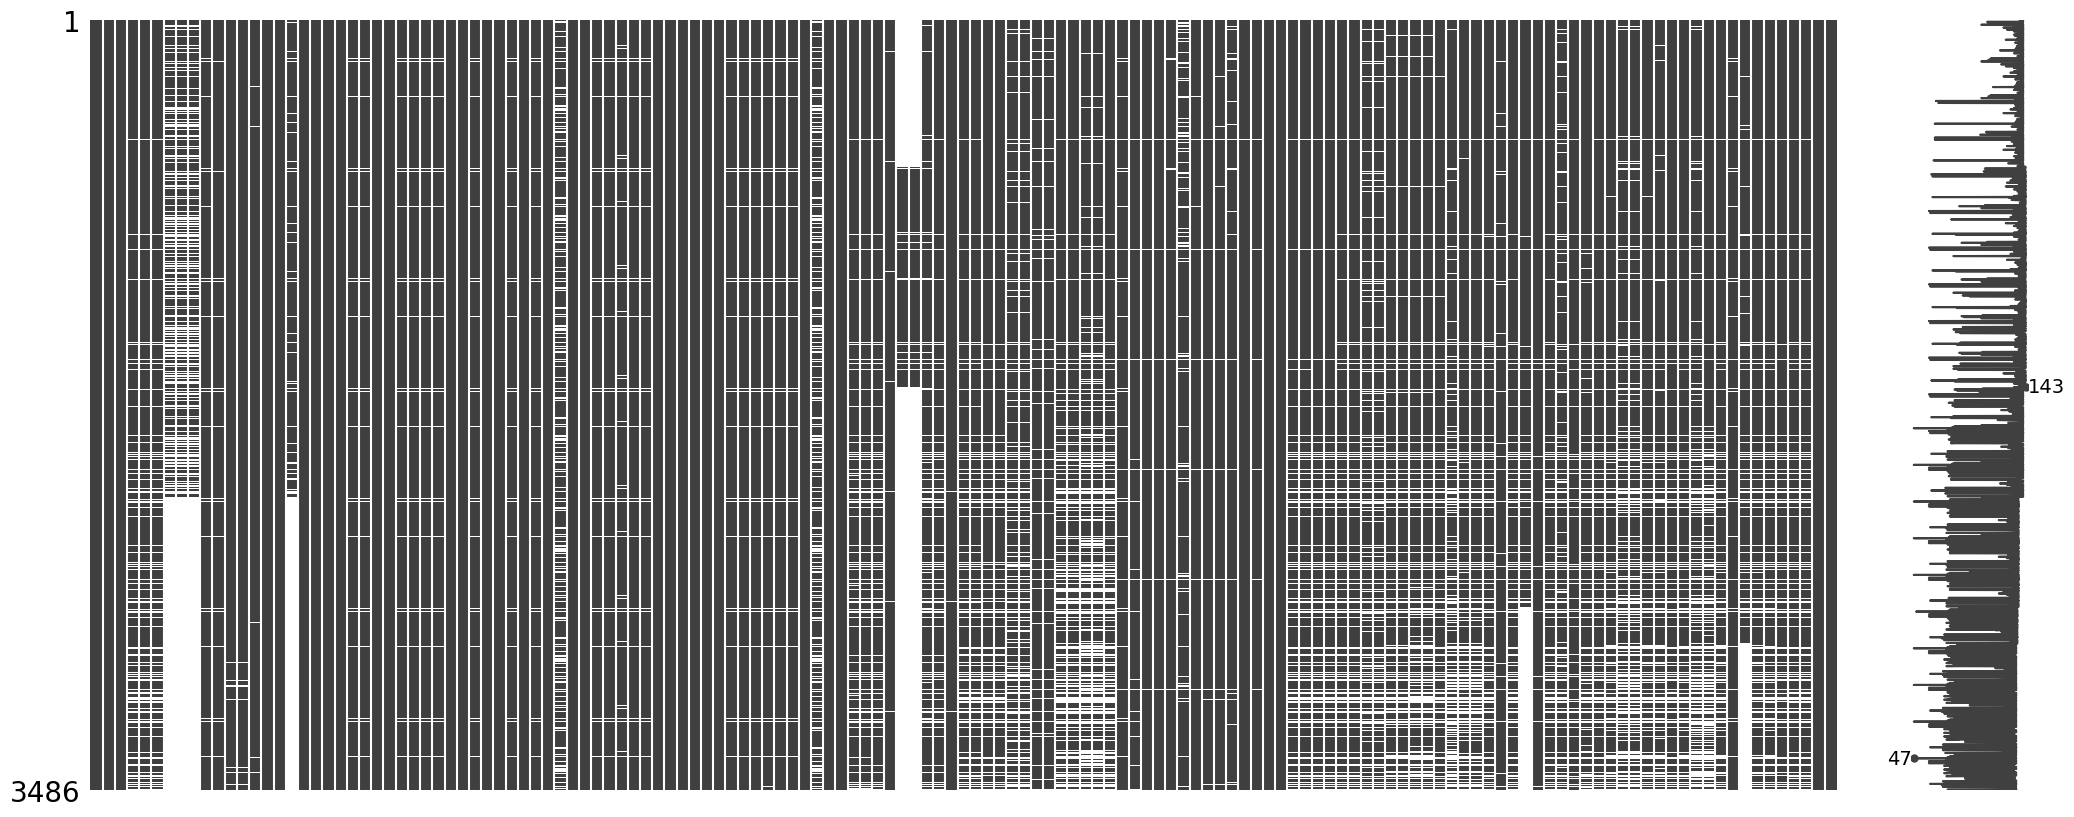

In [41]:
msno.matrix(merged_gdf)

In [42]:
df_copy = merged_gdf.isna().sum()

df_copy = pd.DataFrame(df_copy, columns=['na_count'])

In [43]:
df_copy.sort_values(by='na_count', ascending=False).head(60)# Calculate the percentage of missing values for each column
missing_percent = merged_gdf.isnull().mean() * 100

# Create a DataFrame to display the results
missing_percent_df = pd.DataFrame({'Column': missing_percent.index, 'Missing (%)': missing_percent.values})

# Sort the DataFrame by the percentage of missing values in descending order
missing_percent_df = missing_percent_df.sort_values(by='Missing (%)', ascending=False)

# Display the DataFrame
missing_percent_df.head(35)

,Column,Missing (%)
66,pf_identity_inheritance_widows,73.522662
67,pf_identity_inheritance_daughters,73.522662
6,pf_rol_procedural,59.753299
7,pf_rol_civil,59.753299
8,pf_rol_criminal,59.753299
16,pf_ss_disappearances_organized,43.086632
117,ef_trade_movement_visit,28.829604
59,pf_expression_bti,28.427998
38,pf_assembly_freedom_bti,28.427998
135,ef_regulation_business_licensing,26.907631


In [44]:
# Create a subset with all attributes except for the outcome-variables
df_attributes = merged_gdf.drop(columns=['ef_score','hf_score','pf_score'])

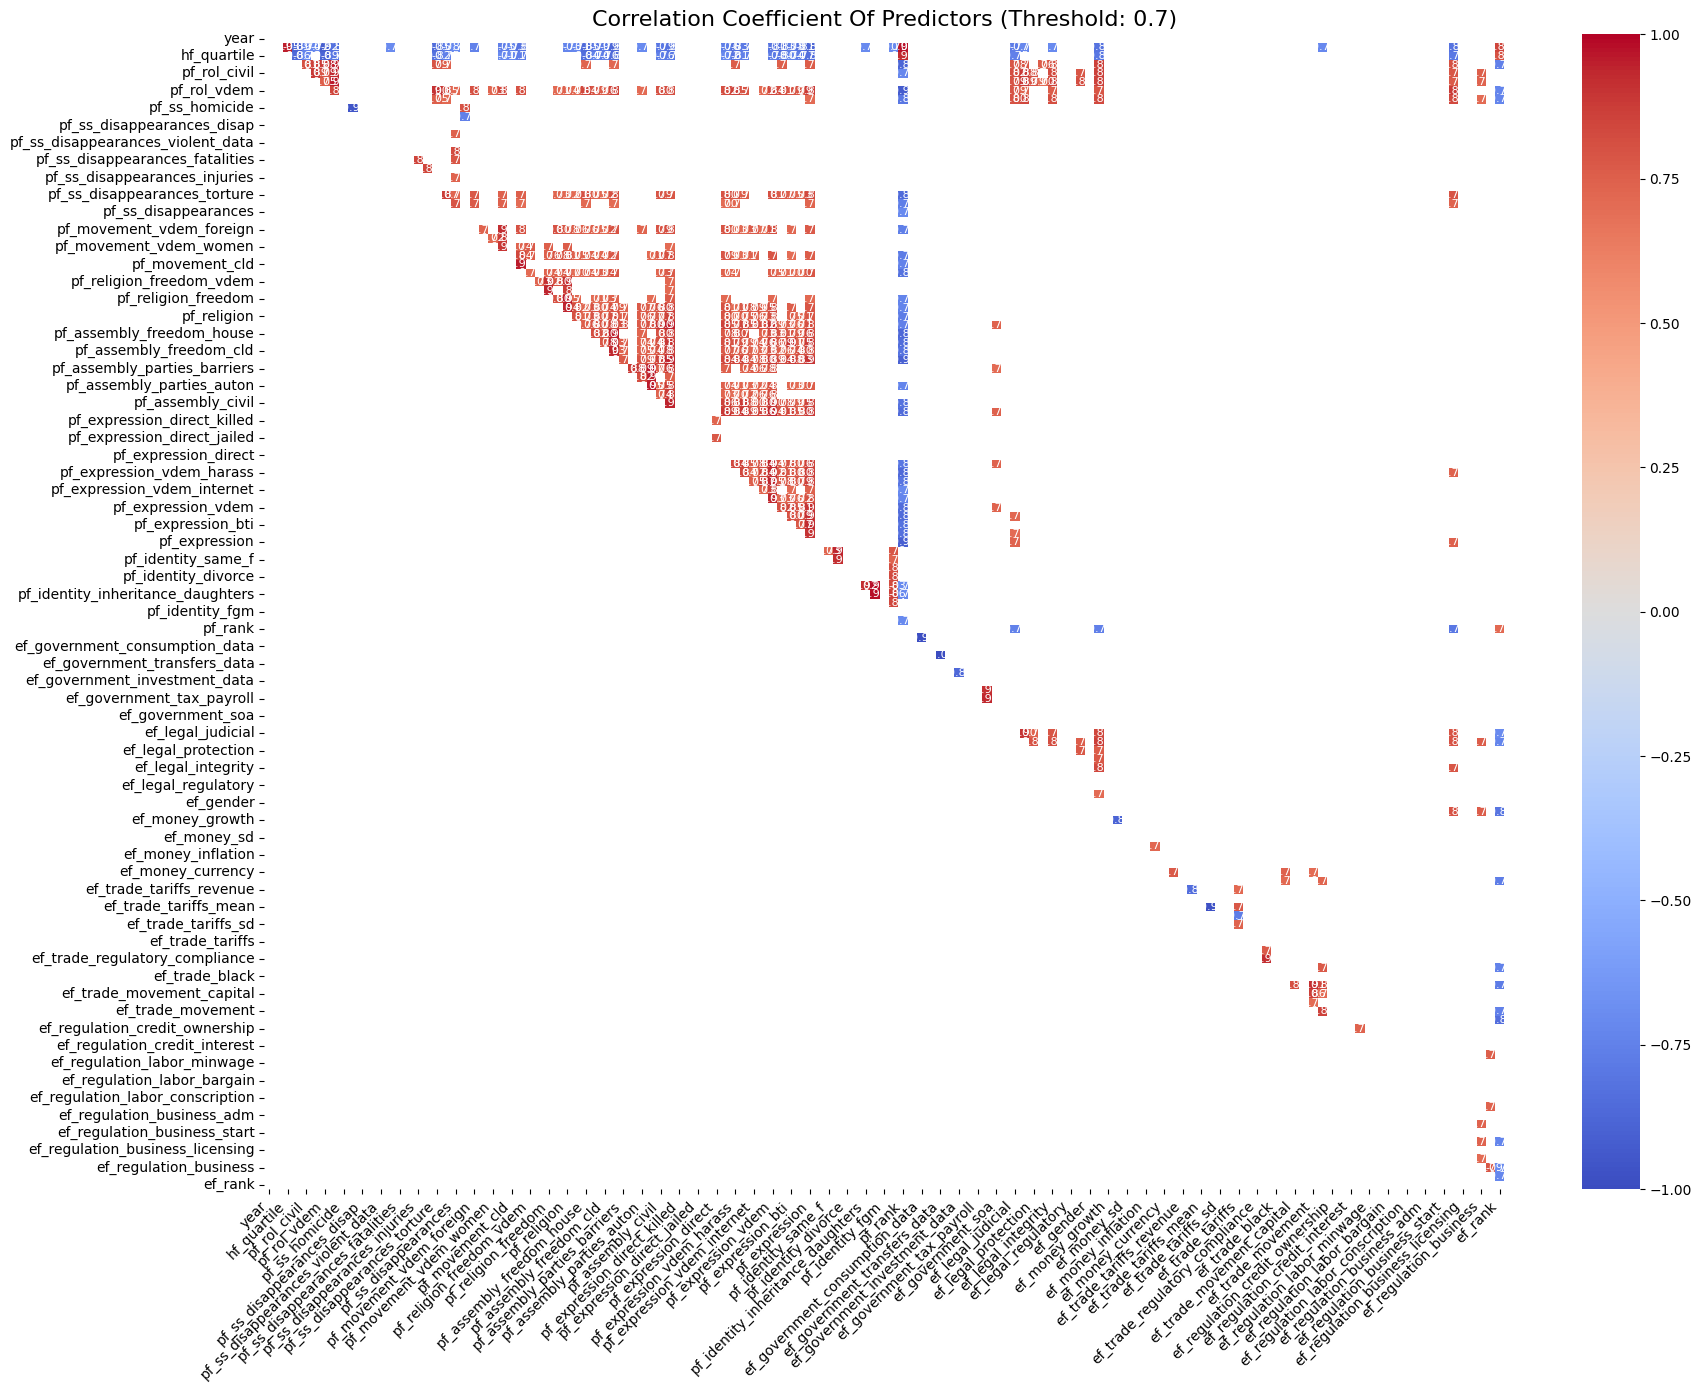

In [45]:
# Heatmap visualizations

# set correlation threshold
corr_threshold = 0.7

# generate correlation matrix
corr_matrix = df_attributes.corr()

# filter to show only highly correlated attributes
high_corr_matrix = corr_matrix[(corr_matrix >= corr_threshold) | (corr_matrix <= -corr_threshold)]

# Generate a mask to only show the bottom triangle
mask = np.tril(np.ones_like(high_corr_matrix, dtype=bool))

# set figure size
plt.figure(figsize=(20, 15))

# generate heatmap
sns.heatmap(high_corr_matrix, annot=True, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})

# rotate x-axis tick labels
plt.xticks(rotation=45, fontsize=10, ha='right')  # Adjust horizontal alignment with `ha` parameter
plt.yticks(fontsize=10)

plt.title(f'Correlation Coefficient Of Predictors (Threshold: {corr_threshold})', fontsize=16)
plt.show()


In [46]:
# Get correlation matrix
corr_matrix = df_attributes.corr()

# Extract features with high correlations
high_correlation_features = set()
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if col != row and abs(corr_matrix.loc[col, row]) > 0.85:
            high_correlation_features.add(col)
            high_correlation_features.add(row)

# Convert the set to a list
high_correlation_features = list(high_correlation_features)

# Print the list of features
print("Features with high correlations:")
for feature in high_correlation_features:
    print(feature)

Features with high correlations:
pf_expression_vdem_harass
pf_religion_freedom_vdem
pf_assembly_freedom_house
ef_government_tax_income
ef_trade
pf_religion_suppression
pf_ss_homicide
pf_expression_vdem_internet
pf_assembly_parties_barriers
pf_movement_cld
pf_expression_house
pf_rank
pf_assembly_entry
ef_trade_movement
pf_expression_vdem_selfcens
ef_government_tax_payroll
pf_ss_homicide_data
pf_religion_freedom_cld
pf_assembly_civil
ef_trade_movement_capital
pf_rol_civil
ef_rank
pf_assembly_parties_bans
ef_regulation_business_impartial
ef_government_tax
pf_identity_same_f
pf_rol
pf_expression_vdem_cultural
pf_assembly_freedom_cld
pf_movement
pf_expression_vdem_gov
pf_rol_procedural
pf_religion_freedom
pf_identity_same
ef_trade_regulatory
pf_movement_vdem
ef_legal_judicial
pf_movement_vdem_women
pf_ss_killings
pf_movement_vdem_men
ef_trade_tariffs_mean
ef_legal_integrity
ef_government_consumption
pf_rol_vdem
pf_assembly_freedom
ef_legal_courts
pf_religion
pf_ss_disappearances_torture
pf_

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def find_high_vif_features(df, considered_features, vif_threshold=10):
    X = df[considered_features].copy()
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.dropna(inplace=True)

    # Add a constant for the VIF calculation
    X['intercept'] = 1

    # Calculate VIF values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Add features with infinite VIF values to high_vif_features list
    inf_vif_features = vif[vif['VIF'] == float('inf')]['Variable'].tolist()
    high_vif_features = inf_vif_features.copy()

    # Remove features with infinite VIF values from VIF DataFrame
    if inf_vif_features:
        print(f"Removing features with infinite VIF values: {', '.join(inf_vif_features)}")
        vif = vif[vif['VIF'] != float('inf')]
        considered_features = list(set(considered_features) - set(inf_vif_features))

    # Iteratively remove features with VIF values above the threshold
    while (vif['VIF'] > vif_threshold).any():
        max_vif_feature = vif.loc[vif['VIF'].idxmax()]['Variable']
        high_vif_features.append(max_vif_feature)
        print(f"Removing {max_vif_feature} with VIF = {vif.loc[vif['VIF'].idxmax()]['VIF']}")
        vif = vif[vif['Variable'] != max_vif_feature]
        considered_features.remove(max_vif_feature)

    return high_vif_features

# Set a VIF threshold
vif_threshold = 10

# Features to consider removing
considered_features = high_correlation_features

# Find features with high VIF
high_vif_features = find_high_vif_features(df_attributes, considered_features, vif_threshold)

Removing features with infinite VIF values: pf_expression_vdem_harass, pf_religion_freedom_vdem, pf_assembly_freedom_house, ef_government_tax_income, pf_religion_suppression, pf_expression_vdem_internet, pf_assembly_parties_barriers, pf_movement_cld, pf_assembly_entry, pf_expression_vdem_selfcens, ef_government_tax_payroll, pf_religion_freedom_cld, pf_assembly_civil, pf_rol_civil, pf_assembly_parties_bans, ef_government_tax, pf_identity_same_f, pf_rol, pf_expression_vdem_cultural, pf_assembly_freedom_cld, pf_movement, pf_expression_vdem_gov, pf_rol_procedural, pf_religion_freedom, pf_identity_same, pf_movement_vdem, pf_movement_vdem_women, pf_movement_vdem_men, ef_trade_tariffs_mean, pf_assembly_freedom, pf_religion, pf_identity_inheritance_daughters, pf_movement_vdem_foreign, pf_identity_inheritance_widows, pf_expression_vdem, pf_identity_inheritance, pf_assembly_freedom_bti, ef_trade_tariffs_mean_data, pf_assembly_parties, pf_identity_same_m, pf_assembly, pf_rol_criminal, pf_assembly

In [48]:
# Remove columns with high VIF from df_attributes
df_attributes.drop(high_vif_features, axis=1, inplace=True)

In [49]:
df_attributes

,year,countries,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_fatalities_data,pf_ss_disappearances_injuries,...,ef_regulation_business_adm,ef_regulation_business_burden,ef_regulation_business_start,ef_regulation_business_impartial,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,country_code,geometry
0,2020,Albania,Eastern Europe,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,5.651538,6.000000,9.742477,5.9975,5.621940,7.175250,6.698118,7.112958,ALB,"POLYGON ((20.07142 42.56091, 20.10208 42.53347..."
1,2020,Algeria,Middle East & North Africa,10.0,9.687083,25.0,5.0,10.000000,0.0,10.000000,...,4.215154,2.222222,9.305002,2.5775,8.771111,7.029528,5.686753,5.778953,DZA,"POLYGON ((8.62203 36.94137, 8.63222 36.88194, ..."
2,2020,Angola,Sub-Saharan Africa,10.0,9.582498,25.0,7.5,9.736578,5.0,9.971733,...,2.937894,3.111111,8.730805,4.7025,7.916416,6.782923,5.696942,6.227545,AGO,"MULTIPOLYGON (((23.98621 -10.87046, 23.98805 -..."
3,2020,Argentina,Latin America & the Caribbean,5.0,10.000000,0.0,7.5,9.925379,2.0,10.000000,...,2.714233,5.555556,9.579288,7.2675,5.726521,6.508295,6.225232,5.490538,ARG,"MULTIPOLYGON (((-68.64312 -54.88861, -68.63723..."
4,2020,Armenia,Caucasus & Central Asia,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,5.170406,5.111111,9.863530,6.2600,9.302574,7.040738,7.124727,7.756333,ARM,"POLYGON ((46.54038 38.87559, 46.51639 38.87804..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,2000,Venezuela,Latin America & the Caribbean,10.0,10.000000,0.0,NaN,10.000000,0.0,10.000000,...,6.417950,6.150000,6.268547,4.3100,NaN,0.315142,4.692328,5.531397,VEN,"MULTIPOLYGON (((-61.18507 8.49674, -61.19417 8..."
3482,2000,Vietnam,South Asia,10.0,10.000000,0.0,NaN,10.000000,0.0,10.000000,...,NaN,NaN,7.885638,3.7000,NaN,0.000000,3.861879,4.416768,VNM,"MULTIPOLYGON (((104.08288 10.36486, 104.08663 ..."
3483,2000,Yemen,Middle East & North Africa,5.0,10.000000,0.0,NaN,8.170079,19.0,7.932996,...,NaN,NaN,NaN,1.1450,NaN,NaN,NaN,NaN,YEM,"MULTIPOLYGON (((52.23416 12.20111, 52.27888 12..."
3484,2000,Zambia,Sub-Saharan Africa,10.0,10.000000,0.0,NaN,10.000000,0.0,9.827262,...,NaN,NaN,8.537578,7.0050,NaN,8.520369,8.020982,6.799421,ZMB,"POLYGON ((32.94040 -9.40508, 32.93944 -9.41583..."


In [50]:
# Reappend the outcome-variables
df_outcome_variables = merged_gdf[['ef_score', 'hf_score', 'pf_score']]

# Concatenate the DataFrames along the columns axis
df_result = pd.concat([df_attributes, df_outcome_variables], axis=1)

In [51]:
df_result

,year,countries,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_fatalities_data,pf_ss_disappearances_injuries,...,ef_regulation_business_impartial,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,country_code,geometry,ef_score,hf_score,pf_score
0,2020,Albania,Eastern Europe,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,5.9975,5.621940,7.175250,6.698118,7.112958,ALB,"POLYGON ((20.07142 42.56091, 20.10208 42.53347...",7.64,7.67,7.69
1,2020,Algeria,Middle East & North Africa,10.0,9.687083,25.0,5.0,10.000000,0.0,10.000000,...,2.5775,8.771111,7.029528,5.686753,5.778953,DZA,"POLYGON ((8.62203 36.94137, 8.63222 36.88194, ...",5.12,5.13,5.13
2,2020,Angola,Sub-Saharan Africa,10.0,9.582498,25.0,7.5,9.736578,5.0,9.971733,...,4.7025,7.916416,6.782923,5.696942,6.227545,AGO,"MULTIPOLYGON (((23.98621 -10.87046, 23.98805 -...",5.91,5.97,6.02
3,2020,Argentina,Latin America & the Caribbean,5.0,10.000000,0.0,7.5,9.925379,2.0,10.000000,...,7.2675,5.726521,6.508295,6.225232,5.490538,ARG,"MULTIPOLYGON (((-68.64312 -54.88861, -68.63723...",4.87,6.99,8.51
4,2020,Armenia,Caucasus & Central Asia,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,6.2600,9.302574,7.040738,7.124727,7.756333,ARM,"POLYGON ((46.54038 38.87559, 46.51639 38.87804...",7.84,8.14,8.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,2000,Venezuela,Latin America & the Caribbean,10.0,10.000000,0.0,NaN,10.000000,0.0,10.000000,...,4.3100,NaN,0.315142,4.692328,5.531397,VEN,"MULTIPOLYGON (((-61.18507 8.49674, -61.19417 8...",5.92,6.43,6.79
3482,2000,Vietnam,South Asia,10.0,10.000000,0.0,NaN,10.000000,0.0,10.000000,...,3.7000,NaN,0.000000,3.861879,4.416768,VNM,"MULTIPOLYGON (((104.08288 10.36486, 104.08663 ...",5.58,5.51,5.48
3483,2000,Yemen,Middle East & North Africa,5.0,10.000000,0.0,NaN,8.170079,19.0,7.932996,...,1.1450,NaN,NaN,NaN,NaN,YEM,"MULTIPOLYGON (((52.23416 12.20111, 52.27888 12...",NaN,NaN,NaN
3484,2000,Zambia,Sub-Saharan Africa,10.0,10.000000,0.0,NaN,10.000000,0.0,9.827262,...,7.0050,NaN,8.520369,8.020982,6.799421,ZMB,"POLYGON ((32.94040 -9.40508, 32.93944 -9.41583...",7.04,7.03,7.03


<AxesSubplot:>

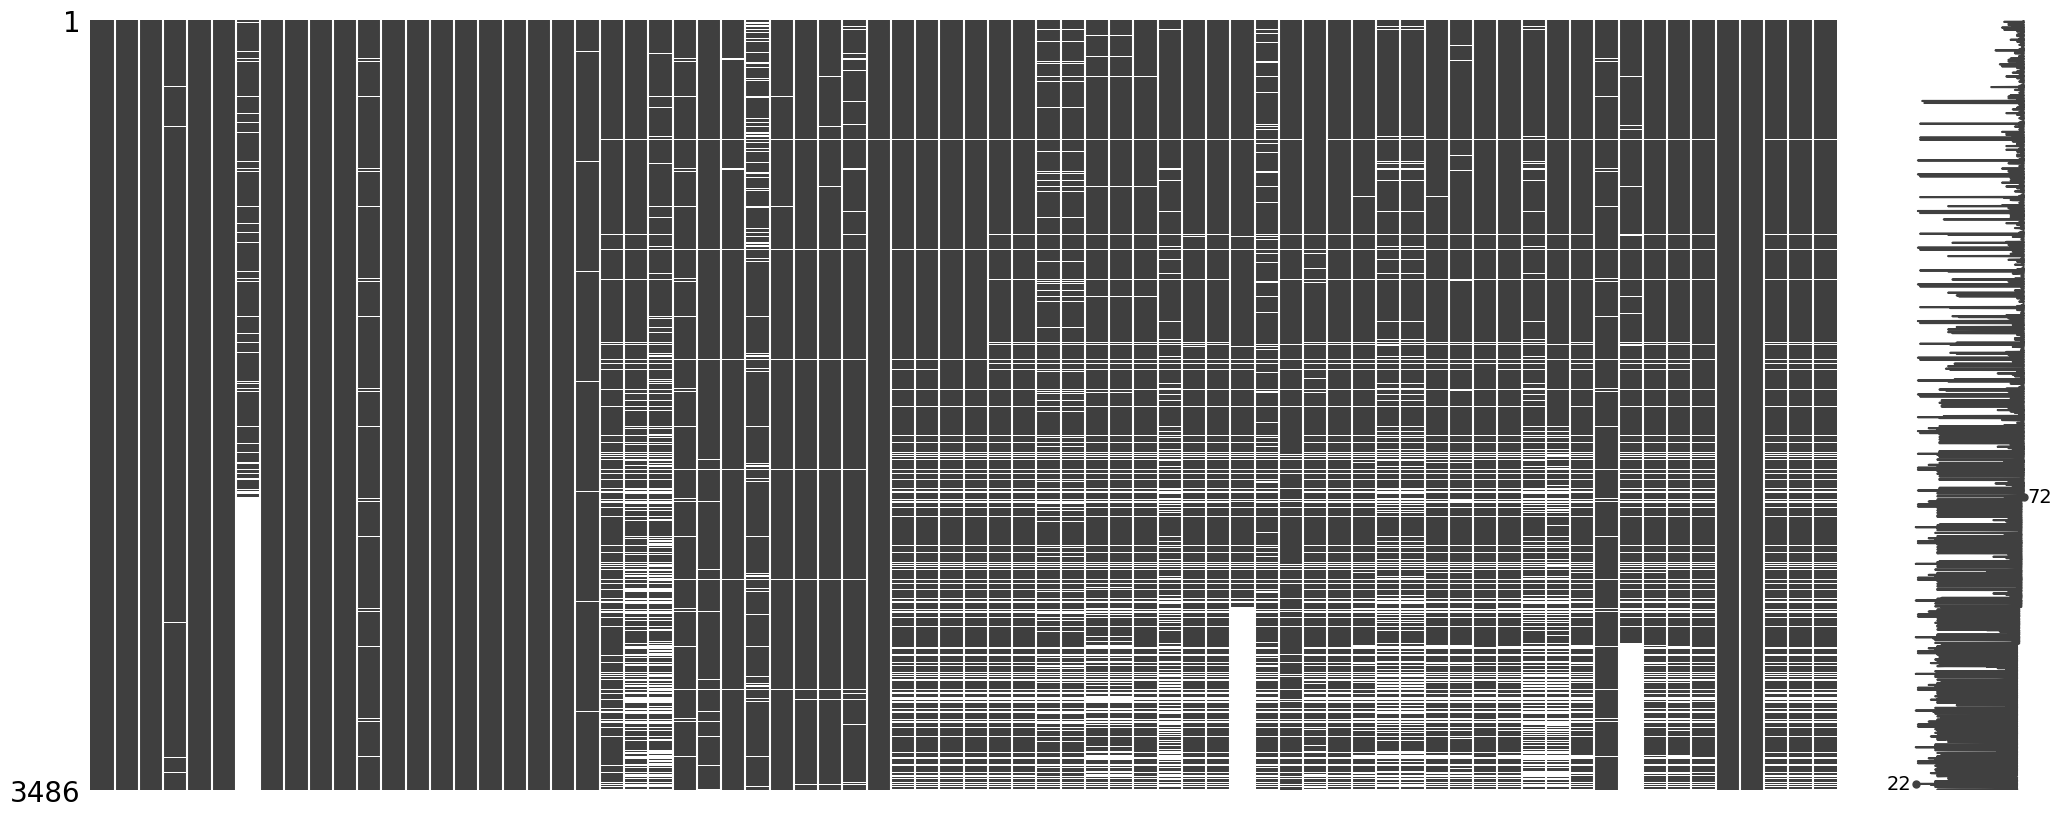

In [52]:
msno.matrix(df_result)

In [53]:
df_result.columns

Index(['year', 'countries', 'region', 'pf_ss_disappearances_disap',
       'pf_ss_disappearances_violent', 'pf_ss_disappearances_violent_data',
       'pf_ss_disappearances_organized', 'pf_ss_disappearances_fatalities',
       'pf_ss_disappearances_fatalities_data', 'pf_ss_disappearances_injuries',
       'pf_ss_disappearances_injuries_data', 'pf_ss_killings',
       'pf_ss_disappearances', 'pf_ss', 'pf_expression_direct_killed',
       'pf_expression_direct_killed_data', 'pf_expression_direct_jailed',
       'pf_expression_direct_jailed_data', 'pf_expression_direct',
       'pf_expression_cld', 'pf_identity_divorce', 'pf_identity_fgm',
       'ef_government_tax_income_data', 'ef_government_tax_payroll_data',
       'ef_government_soa', 'ef_government', 'ef_legal_protection',
       'ef_legal_military', 'ef_legal_integrity', 'ef_legal_enforcement',
       'ef_legal_regulatory', 'ef_legal_police', 'ef_gender', 'ef_money_sd',
       'ef_money_sd_data', 'ef_money_inflation', 'ef_money_inf

## Encoding categorical variables

In [54]:
# One-hot encode the 'countries' and 'region' columns
countries_dummies = pd.get_dummies(df_result['countries'], prefix='country')
region_dummies = pd.get_dummies(df_result['region'], prefix='region')

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df_result, countries_dummies, region_dummies], axis=1)

# Display the resulting DataFrame
df_encoded

,year,countries,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_fatalities_data,pf_ss_disappearances_injuries,...,region_Caucasus & Central Asia,region_East Asia,region_Eastern Europe,region_Latin America & the Caribbean,region_Middle East & North Africa,region_North America,region_Oceania,region_South Asia,region_Sub-Saharan Africa,region_Western Europe
0,2020,Albania,Eastern Europe,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,0,0,1,0,0,0,0,0,0,0
1,2020,Algeria,Middle East & North Africa,10.0,9.687083,25.0,5.0,10.000000,0.0,10.000000,...,0,0,0,0,1,0,0,0,0,0
2,2020,Angola,Sub-Saharan Africa,10.0,9.582498,25.0,7.5,9.736578,5.0,9.971733,...,0,0,0,0,0,0,0,0,1,0
3,2020,Argentina,Latin America & the Caribbean,5.0,10.000000,0.0,7.5,9.925379,2.0,10.000000,...,0,0,0,1,0,0,0,0,0,0
4,2020,Armenia,Caucasus & Central Asia,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,2000,Venezuela,Latin America & the Caribbean,10.0,10.000000,0.0,NaN,10.000000,0.0,10.000000,...,0,0,0,1,0,0,0,0,0,0
3482,2000,Vietnam,South Asia,10.0,10.000000,0.0,NaN,10.000000,0.0,10.000000,...,0,0,0,0,0,0,0,1,0,0
3483,2000,Yemen,Middle East & North Africa,5.0,10.000000,0.0,NaN,8.170079,19.0,7.932996,...,0,0,0,0,1,0,0,0,0,0
3484,2000,Zambia,Sub-Saharan Africa,10.0,10.000000,0.0,NaN,10.000000,0.0,9.827262,...,0,0,0,0,0,0,0,0,1,0


In [55]:
df_encoded.geometry

0       POLYGON ((20.07142 42.56091, 20.10208 42.53347...
1       POLYGON ((8.62203 36.94137, 8.63222 36.88194, ...
2       MULTIPOLYGON (((23.98621 -10.87046, 23.98805 -...
3       MULTIPOLYGON (((-68.64312 -54.88861, -68.63723...
4       POLYGON ((46.54038 38.87559, 46.51639 38.87804...
                              ...                        
3481    MULTIPOLYGON (((-61.18507 8.49674, -61.19417 8...
3482    MULTIPOLYGON (((104.08288 10.36486, 104.08663 ...
3483    MULTIPOLYGON (((52.23416 12.20111, 52.27888 12...
3484    POLYGON ((32.94040 -9.40508, 32.93944 -9.41583...
3485    POLYGON ((30.41576 -15.63187, 30.41729 -15.642...
Name: geometry, Length: 3486, dtype: geometry

In [56]:
# Save the DataFrame as a Parquet file
gdf = gpd.GeoDataFrame(df_encoded, geometry='geometry')

# Save the GeoDataFrame as a GeoParquet file
gdf.to_parquet('gdf_encoded.parquet', compression='snappy', index=False)